# Web scraping: Getting referendum data using Beautiful Soup 

In this post I am going to describe how to get the data of the peace [referendum](https://en.wikipedia.org/wiki/Colombian_peace_agreement_referendum,_2016) (which happened in October the 2nd in Colombia)  from the [official government website](http://plebiscito.registraduria.gov.co/99PL/DPLZZZZZZZZZZZZZZZZZ_L1.htm) using [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#) in python (this a task was suggested by [Sebastian Martinez](https://co.linkedin.com/in/sebasti%C3%A1n-mart%C3%ADnez-00184649)). The data is not directly available but is represened as follows:

<img src="images/plebiscito_datos_image.png" alt="plebiscito_datos_image" style="width: 800px;"/>

The aim is to get the percentages of votes for each town in Colombia by scraping the website.

**Warning:** I want to emphasize that this post **does not** involve analizing the data or getting conclusions from it. These kind of analysis should be done carefully and responsibly.

## Step 1: Setting up the enviorment.

In [1]:
# This is the principal website of the referendum. 
url_main="http://plebiscito.registraduria.gov.co"

# This is the complete url of the website of the referendum. 
url = "http://plebiscito.registraduria.gov.co/99PL/DPLZZZZZZZZZZZZZZZZZ_L1.htm"

The html code of *url* looks like:

<img src="images/html_image.png" alt="html" style="width: 800px;"/>

In [2]:
from bs4 import BeautifulSoup
import requests

# This function gets the html of the website. 
def get_soup(s):
    r  = requests.get(s)
    data = r.text
    soup = BeautifulSoup(data, "lxml")
    return soup


soup = get_soup(url)

## Step 2: Getting the departments (states) information

Here we pick the information of each department as a list.
Each element of the list is of type bs4.element.Tag

*Remark:* You need to explore thr html code to find out that `find_all("option")[56:90]` actually gets the departments names.

In [3]:
departments_soup = soup.find_all("option")[56:90]

We construct from the departments_soup a pandas DataFrame. 
It contains two columns: 
1. The name of the department. 
2. The path to each department result page (where detailed infromation is provided).  

In [4]:
import pandas as pd

departments = pd.DataFrame(columns=("Department", "path"))

for i in range (0,len(departments_soup)):
    row=pd.Series(dict(zip(["Department", "path"],
                           [departments_soup[i].get_text(),
                            departments_soup[i]["value"]])))
    row.name = i
    departments = departments.append(row)

# Let us see the result.    
departments

,Department,path
0,AMAZONAS,../99PL/DPL60ZZZZZZZZZZZZZZZ_L1.htm
1,ANTIOQUIA,../99PL/DPL01ZZZZZZZZZZZZZZZ_L1.htm
2,ARAUCA,../99PL/DPL40ZZZZZZZZZZZZZZZ_L1.htm
3,ATLANTICO,../99PL/DPL03ZZZZZZZZZZZZZZZ_L1.htm
4,BOGOTA D.C.,../99PL/DPL16ZZZZZZZZZZZZZZZ_L1.htm
5,BOLIVAR,../99PL/DPL05ZZZZZZZZZZZZZZZ_L1.htm
6,BOYACA,../99PL/DPL07ZZZZZZZZZZZZZZZ_L1.htm
7,CALDAS,../99PL/DPL09ZZZZZZZZZZZZZZZ_L1.htm
8,CAQUETA,../99PL/DPL44ZZZZZZZZZZZZZZZ_L1.htm
9,CASANARE,../99PL/DPL46ZZZZZZZZZZZZZZZ_L1.htm


Looking into the data we see that there are two deparments (Nariño and Norte de Santander) with misspellings. 

In [5]:
departments.loc[22,"Department"] = "NARIÑO"
departments.loc[23,"Department"] = 'NORTE DE SANTANDER'

From each department path we construct the real url and store it in a new column in the deparments DataFrame called "url".

In [6]:
def construct_complete_url(path):
    complete_url = url_main + path.split("..")[1]
    return complete_url

departments["url"]=departments["path"].apply(lambda x: construct_complete_url(x))

In [7]:
# Let us see the head of the resulting DataFrame.
departments.head()

,Department,path,url
0,AMAZONAS,../99PL/DPL60ZZZZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...
1,ANTIOQUIA,../99PL/DPL01ZZZZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...
2,ARAUCA,../99PL/DPL40ZZZZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...
3,ATLANTICO,../99PL/DPL03ZZZZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...
4,BOGOTA D.C.,../99PL/DPL16ZZZZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...


We create a new column in the deparments DataFrame called *soup*. This column stores a soup object obtained from their corresponding url.

In [8]:
 departments["soup"]=departments["url"].apply(lambda x : get_soup(x))

## Step 3: Getting the  towns information

We make from the departments a pandas DataFrame of towns. It contains three columns: 
1. The name of the department. 
2. The name of the town. 
3. The path to each department result. 

In [9]:
towns = pd.DataFrame(columns=("Department", "Town", "path"))

for j in range(0,departments.shape[0]):
    
    towns_in_department = departments["soup"][j].find_all("option")[36:]
    
    for i in range (0,len(towns_in_department)):
        dept = departments.loc[j,"Department"]
        town_name = towns_in_department[i].get_text()
        town_path = towns_in_department[i]["value"]
        row = pd.Series(dict(zip(["Department", "Town", "path"],[dept,town_name,town_path])))
        towns = towns.append(row, ignore_index=True)

In [10]:
# Let us see the structure for the first 20 towns.
towns.head(20)

,Department,Town,path
0,AMAZONAS,EL ENCANTO,../99PL/DPL60010ZZZZZZZZZZZZ_L1.htm
1,AMAZONAS,LA CHORRERA,../99PL/DPL60013ZZZZZZZZZZZZ_L1.htm
2,AMAZONAS,LA PEDRERA,../99PL/DPL60016ZZZZZZZZZZZZ_L1.htm
3,AMAZONAS,LA VICTORIA,../99PL/DPL60017ZZZZZZZZZZZZ_L1.htm
4,AMAZONAS,LETICIA,../99PL/DPL60001ZZZZZZZZZZZZ_L1.htm
5,AMAZONAS,MIRITI PARANA,../99PL/DPL60019ZZZZZZZZZZZZ_L1.htm
6,AMAZONAS,PUERTO ALEGRIA,../99PL/DPL60030ZZZZZZZZZZZZ_L1.htm
7,AMAZONAS,PUERTO ARICA,../99PL/DPL60040ZZZZZZZZZZZZ_L1.htm
8,AMAZONAS,PUERTO NARIÃO,../99PL/DPL60007ZZZZZZZZZZZZ_L1.htm
9,AMAZONAS,PUERTO SANTANDER,../99PL/DPL60021ZZZZZZZZZZZZ_L1.htm


We create a new column in the towns DataFrame called *url*. This coumn stores the real url for each town. 

In [11]:
towns["url"]=towns["path"].apply(lambda x: construct_complete_url(x))

In [12]:
# Let us see the result.
towns.head()

,Department,Town,path,url
0,AMAZONAS,EL ENCANTO,../99PL/DPL60010ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...
1,AMAZONAS,LA CHORRERA,../99PL/DPL60013ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...
2,AMAZONAS,LA PEDRERA,../99PL/DPL60016ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...
3,AMAZONAS,LA VICTORIA,../99PL/DPL60017ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...
4,AMAZONAS,LETICIA,../99PL/DPL60001ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...


## Step 4: Get votes 

Now that we have access to each town website results, we are going to get the percentage of yes, no and null votes.

In [13]:
# This function transform the vote string of the function below 
# in order to get an integer. 

# To understan the logic of this function you need to understand 
# the structure of the html code.

def get_vote_int_from_string(vote_string, is_null_votes):
    
    if(is_null_votes):
        num_v = vote_string.split("Votos nulos")[1]
    else:
        num_v = vote_string.split("(")[1].split( )[0]
    
    num = "".join(num_v.split(".")) 
    return int(num)
    
# This function gets the votation information.
def get_votes(u):
    s=get_soup(u)
    
    yes = s.find_all("div", class_="skill-bar-percent")[1].get_text()
    no = s.find_all("div", class_="skill-bar-percent")[3].get_text()
    null = s.find_all("div", class_="cajaInfTercera")[0].find_all("div", class_="contenido")[0].get_text()

    votes = (get_vote_int_from_string(yes, False), 
             get_vote_int_from_string(no, False),
             get_vote_int_from_string(null, True))
    
    return votes

We create a new column in the towns DataFrame called *votes* which stores the information in a tuple.

In [14]:
towns["votes"]=towns["url"].apply(lambda x : get_votes(x))

In [15]:
towns.head()

,Department,Town,path,url,votes
0,AMAZONAS,EL ENCANTO,../99PL/DPL60010ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(170, 51, 2)"
1,AMAZONAS,LA CHORRERA,../99PL/DPL60013ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(300, 62, 3)"
2,AMAZONAS,LA PEDRERA,../99PL/DPL60016ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(189, 25, 1)"
3,AMAZONAS,LA VICTORIA,../99PL/DPL60017ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(4, 1, 0)"
4,AMAZONAS,LETICIA,../99PL/DPL60001ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(4403, 4463, 84)"


Next we get the yes, no and null votes separately. We also compute the total of votes.

In [16]:
# We get YES. 
towns["YES"] = towns["votes"].apply(lambda x : x[0])

# We get NO. 
towns["NO"] = towns["votes"].apply(lambda x : x[1])

# We get NULL. 
towns["NULL"] = towns["votes"].apply(lambda x : x[2])

# We comute the total (sum). 
towns["TOTAL"] = towns["votes"].apply(lambda x : sum(x))

In [17]:
# Let us see the final strcuture. 
towns.head()

,Department,Town,path,url,votes,YES,NO,NULL,TOTAL
0,AMAZONAS,EL ENCANTO,../99PL/DPL60010ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(170, 51, 2)",170,51,2,223
1,AMAZONAS,LA CHORRERA,../99PL/DPL60013ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(300, 62, 3)",300,62,3,365
2,AMAZONAS,LA PEDRERA,../99PL/DPL60016ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(189, 25, 1)",189,25,1,215
3,AMAZONAS,LA VICTORIA,../99PL/DPL60017ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(4, 1, 0)",4,1,0,5
4,AMAZONAS,LETICIA,../99PL/DPL60001ZZZZZZZZZZZZ_L1.htm,http://plebiscito.registraduria.gov.co/99PL/DP...,"(4403, 4463, 84)",4403,4463,84,8950


# Step 5: Export the data into a csv file

We export the towns DataFrame into a .csv file with all the data. 

In [18]:
columns_to_print = ["Department", "Town", "YES", "NO", "NULL", "TOTAL"]

towns[columns_to_print].to_csv("resultados.csv", index=False)

# Step 6: Data Exploration

Let us see how to begin a simple exploration of the data.

In [19]:
data = pd.read_csv("resultados.csv", index_col="Department")

data.head()

,Town,YES,NO,NULL,TOTAL
Department,,,,,
AMAZONAS,EL ENCANTO,170,51,2,223
AMAZONAS,LA CHORRERA,300,62,3,365
AMAZONAS,LA PEDRERA,189,25,1,215
AMAZONAS,LA VICTORIA,4,1,0,5
AMAZONAS,LETICIA,4403,4463,84,8950


In order to get information from each department we group the results by adding the total votes for each category.

In [20]:
results_departments = data.groupby(data.index).sum()

Now we compute basic ratios of the results.

In [21]:
results_departments["YES/TOTAL"] = results_departments["YES"]/results_departments["TOTAL"]
results_departments["NO/TOTAL"] = results_departments["NO"]/results_departments["TOTAL"]

results_departments.head()

,YES,NO,NULL,TOTAL,YES/TOTAL,NO/TOTAL
Department,,,,,,
AMAZONAS,6524,4994,114,11632,0.560867,0.429333
ANTIOQUIA,648051,1057518,22416,1727985,0.375033,0.611995
ARAUCA,28653,30274,1523,60450,0.473995,0.500811
ATLANTICO,258121,168300,2132,428553,0.602308,0.392717
BOGOTA D.C.,1423612,1114933,25213,2563758,0.555283,0.434882


### Visualization

Here we plot the `YES/TOTAL` ratio for all the departments.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

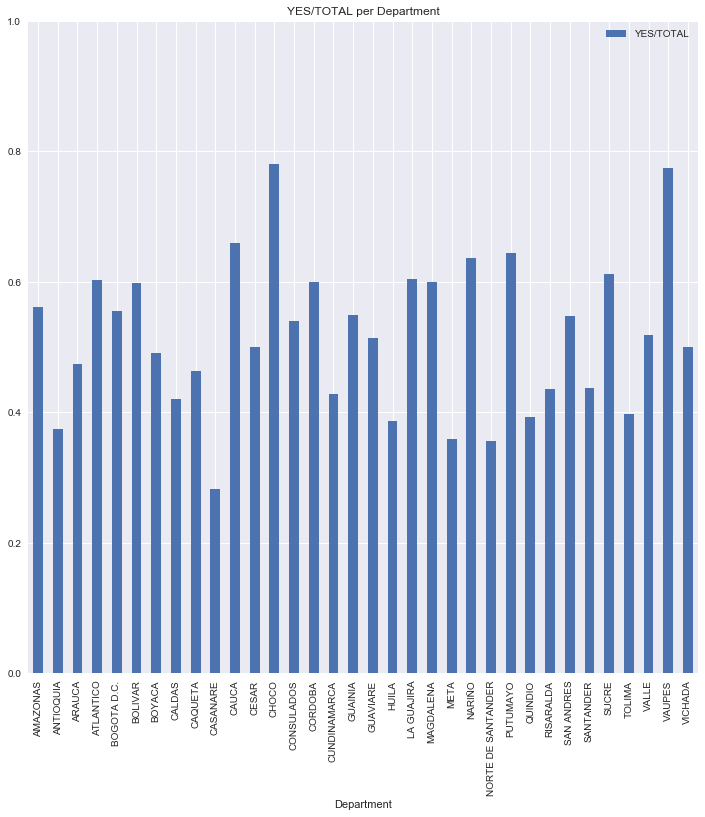

In [22]:
import matplotlib as plt
import seaborn as sns
%matplotlib inline

results_departments.plot(y="YES/TOTAL",
                         kind='bar',
                         stacked=True,
                         title="YES/TOTAL per Department",
                         ylim=(0,1.0),
                         figsize=(12,12))
plt.pyplot.xticks(rotation=90)

Here we plot the `TOTAL` votation for all the departments.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

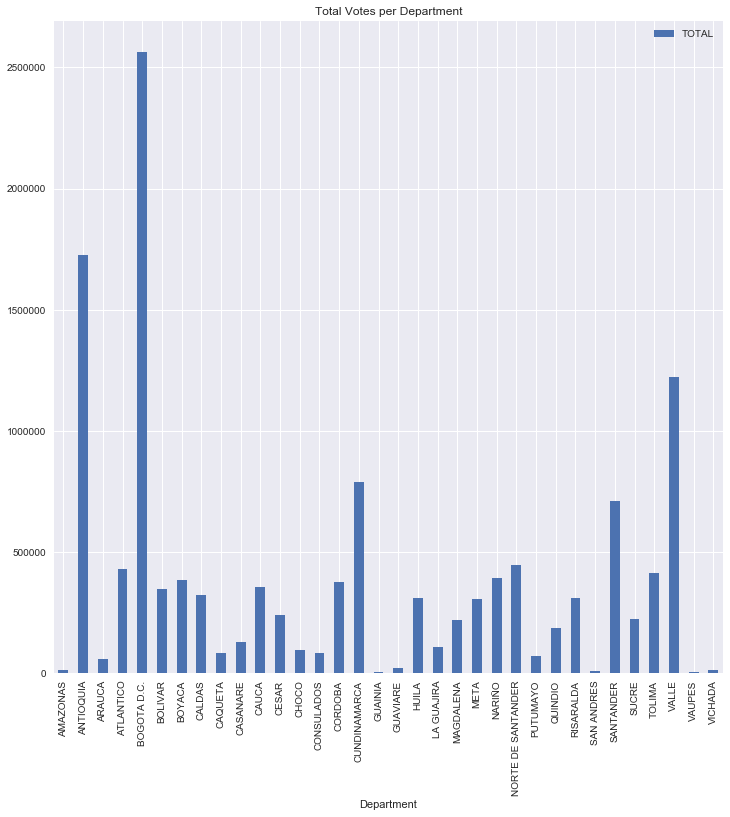

In [23]:
results_departments.plot(y="TOTAL", 
                         kind='bar',
                         title="Total Votes per Department",
                         figsize=(12,12))
plt.pyplot.xticks(rotation=90)

Now we want to get information within each department.

In [24]:
results_towns = data.copy()

results_towns["YES/TOTAL"]=results_towns["YES"]/results_towns["TOTAL"]
results_towns["NO/TOTAL"]=results_towns["NO"]/results_towns["TOTAL"]

results_towns.head()

,Town,YES,NO,NULL,TOTAL,YES/TOTAL,NO/TOTAL
Department,,,,,,,
AMAZONAS,EL ENCANTO,170,51,2,223,0.762332,0.228700
AMAZONAS,LA CHORRERA,300,62,3,365,0.821918,0.169863
AMAZONAS,LA PEDRERA,189,25,1,215,0.879070,0.116279
AMAZONAS,LA VICTORIA,4,1,0,5,0.800000,0.200000
AMAZONAS,LETICIA,4403,4463,84,8950,0.491955,0.498659


Here we plot the `YES/TOTAL` ratio for the deparment `CHOCO`.

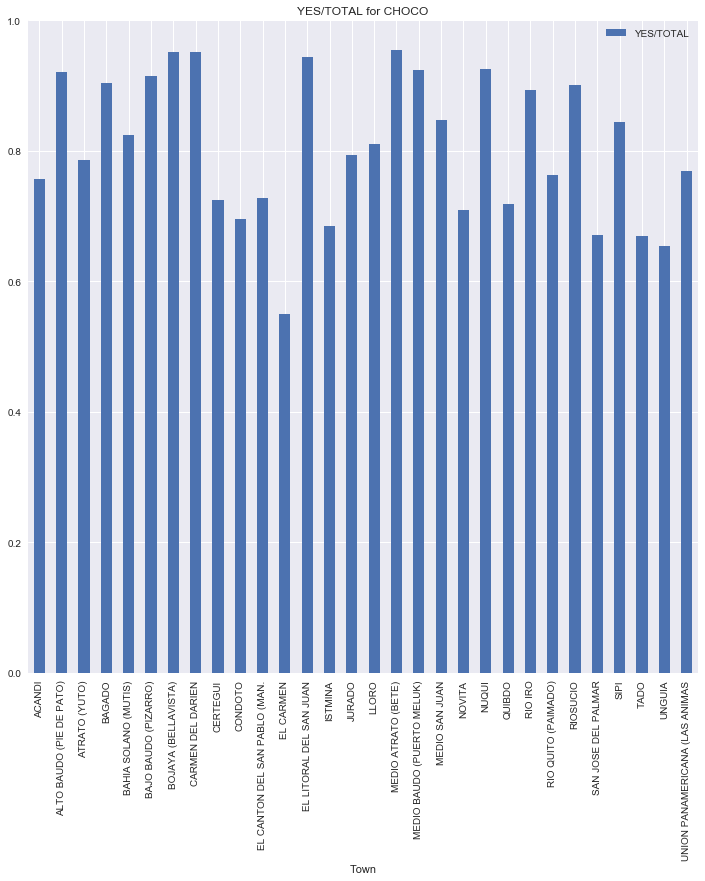

In [25]:
results_towns[results_towns.index=="CHOCO"].plot(x="Town", y="YES/TOTAL",
                                                  kind='bar', 
                                                  title="YES/TOTAL for CHOCO",
                                                  figsize=(12,12),
                                                  ylim=(0,1.0))

Here we plot the `YES/TOTAL` ratio for the deparment `CHOCO`.

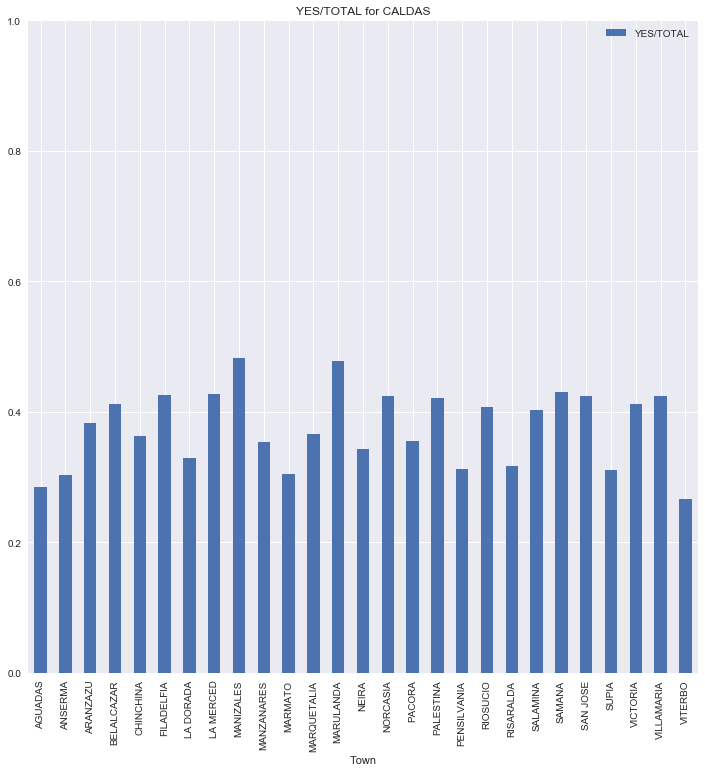

In [26]:
results_towns[results_towns.index=="CALDAS"].plot(x="Town", y="YES/TOTAL",
                                                  kind='bar', 
                                                  title="YES/TOTAL for CALDAS",
                                                  figsize=(12,12),
                                                  ylim=(0,1.0))

As mentioned in the introduction, now that the data is available it is necessary to make a detailed and structured study of these results. For example, mapping these results to education level, precense of the guerrilla, etc. Of course, this is something which, for now, is beyond the scope of this post. 